## Collaboration Platform Analysis Case Study


### i. About the analysis
The analysis will forcus on :
 - general behavior of adopted users by measuring the stickiness DAU (Daily Active Users) and MAU (Monthly Active Users) ratio of these adopted users over time.
 - best predictions fro adopted users.

### ii. About the datasets

The data has the following two files:

A user file ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

- name: the user's name

- object_id: the user's id

- email: email address

- email_domain: domain of email address, e.g. gmail.com

- creation_source: how they signed up for the product. This takes on one of 5 values:

    - PERSONAL_PROJECTS: invited to join another user's personal workspace

    - GUEST_INVITE: invited to an organization as a guest (limited permissions)

    - ORG_INVITE: invited to an organization (as a full member)

    - SIGNUP: signed up via main website

    - SIGNUP_GOOGLE_AUTH: signed up using Google

- Authentication (using a Google email account for their login id)

- creation_time: when they created their account

- last_session_creation_time: unix timestamp of last login

- opted_in_to_mailing_list: whether they have opted into receiving marketing emails

- enabled_for_marketing_drip: whether they are on the regular marketing email drip

- org_id: the organization (group of users) they belong to

- invited_by_user_id: which user invited them to join (if applicable).

A usage summary file ("takehome_user_engagement") that has a row for each day that a user logged into the product.

## Step 1: Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas import DataFrame, Series
import datetime as dt
import time 
import pytz 

sns.set(style = 'white')
sns.set(style = 'whitegrid', color_codes= True)
sns.set_palette('husl')

In [3]:
# !pip3 install fbprophet
# !pip3 install prophet
# !pip3 install pystan 

In [4]:
# Prophet tiem-series analysis package
from prophet import Prophet
import datetime
from datetime import datetime

In [5]:
# !pip3 install imblearn

In [6]:
# Address imbalance data
from imblearn.over_sampling import SMOTE

In [7]:
# Preprocessing 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Gridsearch for hyperparameter tuning 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [8]:
# Feature selection
from sklearn import datasets
from sklearn.feature_selection import RFE

In [9]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

In [10]:
# !pip3 install xgboost

In [11]:
# XGBoost
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [12]:
# Logistics regression 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

In [13]:
# Confussion matrix
from sklearn.metrics import confusion_matrix

In [14]:
# ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Step 2: Load Data

In [15]:
user_cnt = pd.read_csv('takehome_user_engagement.csv',encoding = "ISO-8859-1",parse_dates=['time_stamp'])
user_eng = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1",parse_dates=['creation_time'])

In [16]:
# Info about the takehome_user_engagement.csv dataset
user_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [17]:
# Info about the takehome_users.csv dataset
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [18]:
# The first five rows of the dataframe user_cnt
user_cnt.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [19]:
len(user_cnt['user_id'].unique())

8823

In [20]:

# The first five rows of the dataframe user_eng
user_eng.sort_values(by='creation_time').head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
3860,3861,2012-05-31 00:43:27,Jensen Stine,StineAJensen@yahoo.com,ORG_INVITE,1.338684e+09,0,0,115,3861.0
11429,11430,2012-05-31 01:42:31,Wood Levi,LeviWood@hotmail.com,ORG_INVITE,1.338515e+09,0,0,239,5677.0
7169,7170,2012-05-31 06:23:51,Cavalcanti Leonardo,LeonardoPereiraCavalcanti@hotmail.com,ORG_INVITE,1.345444e+09,0,0,145,7170.0
10011,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,1.338452e+09,0,1,225,7104.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN



## Step 3: Data Cleanning and Manipulation  by Filltering out Adopted Users

In [21]:
# Users who have at least 3 logs regardless of the time frame
# user_cnt_3_log = user_cnt.groupby('user_id')
user_cnt_3_log = user_cnt.groupby('user_id').filter(lambda x : len(x) >= 3)

In [22]:
print(user_cnt_3_log.shape) # Check the shape of the user_cnt_3_log dataset
print(user_cnt.shape) 
print(len(user_cnt_3_log['user_id'].unique())) # There are 2248 users who have more than three logs

(201002, 3)
(207917, 3)
2248


In [23]:
def adopted_user(duration, logs, user_ids):
    # The adopted_users is aimed to filter out only adopted users who logged in at least 3 seperate days within 7-day period
    # Ags: duration - 7 days
         # logs - number of logs in here which will be 3 logs
         # users_ids - unique user id
    # Return: adopted - boolean value that returns whether the user has at least 3 logins within a 7-days period
    
    tol_unique_users = len(user_ids.index)
    day = 0
    user_log = 1
    adopted = False
    
    while user_log < logs: # Keep iterating if the users loggin is smaller than 3-log cap
        if (day + 2) < tol_unique_users: # keep iterating for each unique user
            # this statement guarantee the next row is within 7 days and the previous row is within 1 day
            if user_ids['time_stamp'].iloc[day + 1] - user_ids['time_stamp'].iloc[day] <= pd.Timedelta(days = duration) \
            and (user_ids['time_stamp'].iloc[day + 1] - user_ids['time_stamp'].iloc[day]) > pd.Timedelta(days=1) :
                user_log += 1 # log user activity when the users loggin in 2 times
                new_timeframe = (user_ids['time_stamp'].iloc[day + 1] - user_ids['time_stamp'].iloc[day])
                
                # check to see if the next row is within the number of days above and the previous row is within 1 day
                if (user_ids['time_stamp'].iloc[day + 2] - user_ids['time_stamp'].iloc[day + 1]) <= new_timeframe \
                and (user_ids['time_stamp'].iloc[day + 2] - user_ids['time_stamp'].iloc[day + 1]) > pd.Timedelta(days = 1):
                    user_log += 1 # increse the user's logging time by 1 and the loop will stop when it's equal to 3
                    adopted = True # when the user has at least 3 logs, it will return true
                    
                else:
                    day += 1
                    user_log = 1
            else:
                day += 1
                user_log = 1
        else:
            user_log = logs
    
    return adopted
            
    

In [24]:
user_id_group = user_cnt_3_log.groupby('user_id')

In [25]:
# apply the adopted_user function to the filter
adopted_users_df  = user_id_group.filter(lambda x: adopted_user(duration = 7, logs = 3, user_ids = x)== True)

In [26]:

# get the sense of how the table looks like
adopted_users_df.head()

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


In [27]:

adopted_users_df.shape # check the shape of this table

(197589, 3)

In [28]:
# create a new dataframe which contains all unique user_id
adopted_user_id = pd.DataFrame(adopted_users_df['user_id'].unique())
adopted_user_id.columns = ['user_id'] #name the column 
adopted_user_id.head()

,user_id
0,2
1,10
2,33
3,42
4,50


In [29]:
adopted_user_id.shape #there are 1615 unique adopted user_ids

(1615, 1)




## Step 4: EDA 

### 4.1 Stickness (DAU/MAU) of adopted users over time

### a. Caculate DAU (Daily Acticve Users):


In [30]:
# make a copy of the original dataframe
adopted_users_df_1 = adopted_users_df.copy()

# truncate date time data to 'date'
adopted_users_df_1['time_stamp'] = adopted_users_df_1['time_stamp'].dt.floor('d') #rounds down the datetime values to the nearest day.
adopted_users_df_1['time_stamp'] = pd.to_datetime(adopted_users_df_1['time_stamp'])

In [31]:
adopted_users_df_1['time_stamp'].head()

1   2013-11-15
2   2013-11-29
3   2013-12-09
4   2013-12-25
5   2013-12-31
Name: time_stamp, dtype: datetime64[ns]

In [71]:
# calculate the sum of logs by each date
adopted_users_df_2 = adopted_users_df_1[['time_stamp','visited']].groupby('time_stamp').sum()
adopted_users_df_2.head()

,visited
time_stamp,
2012-05-31,2
2012-06-01,1
2012-06-02,1
2012-06-03,2
2012-06-04,2


In [33]:
print(adopted_users_df_1.shape)
print(adopted_users_df_2.shape)

(197589, 3)
(734, 1)


In [72]:
# keep only the time frame that is coherent with the analysis
adopted_users_df_2 = adopted_users_df_2.reset_index()
adopted_users_df_2 = adopted_users_df_2.loc[adopted_users_df_2['time_stamp'] > '2012-05-01']
adopted_users_df_2 = adopted_users_df_2.loc[adopted_users_df_2['time_stamp'] < '2014-05-01']
adopted_users_df_2 = adopted_users_df_2.set_index('time_stamp')

In [73]:
adopted_users_df_2.head()

,visited
time_stamp,
2012-05-31,2
2012-06-01,1
2012-06-02,1
2012-06-03,2
2012-06-04,2


In [74]:
print(adopted_users_df_2.shape)

(699, 1)


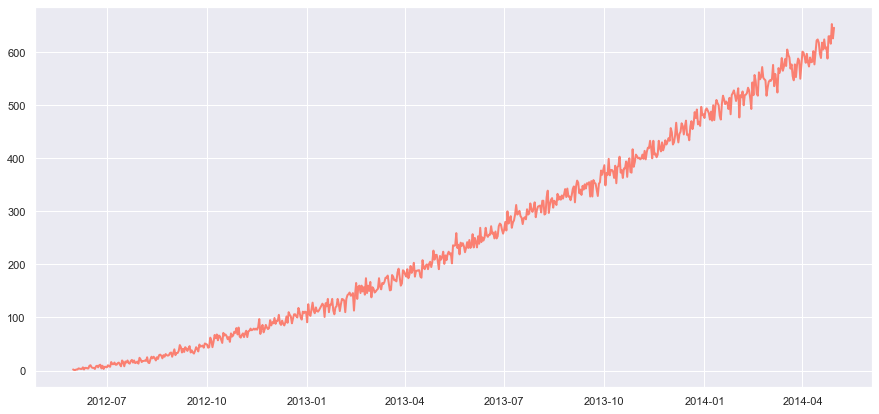

In [81]:
# Create a line plot to see the trend of DAU over time
sns.set(rc={'figure.figsize':(15,7)})  #is a dictionary specifying the size of the figure (plot) in inches. The width is set to 15 inches, and the height is set to 7 inches.
fig, ax = plt.subplots()
ax.plot(adopted_users_df_2['visited'], linewidth = 2, color = 'salmon')

# Set x-ticks to yearly interval and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
# ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('DAU')
ax.set_title('Number of DAU over time')

The plot shows a significant increase in DAU over 2 years period.

### b. Calulate MAU (Monthly Active Users):

In [85]:
# make a copy of the original dataframe
adopted_users_df_3 = adopted_users_df.copy()

# truncate date time data to 'month - year'
adopted_users_df_3['time_stamp'] = pd.to_datetime(adopted_users_df_3['time_stamp']).dt.to_period('M')
adopted_users_df_4 = adopted_users_df_3[['time_stamp', 'visited']].groupby('time_stamp').sum()

# the first five rows of the dataset
adopted_users_df_4.head()


,visited
time_stamp,
2012-05,2
2012-06,154
2012-07,432
2012-08,757
2012-09,1211


In [84]:
print(adopted_users_df_4.shape)

(26, 1)


In [92]:
adopted_users_df_4.index = adopted_users_df_4.index.values.astype('datetime64[M]')
adopted_users_df_4.index.name = ('time_stamp')
                                                                 

In [93]:
adopted_users_df_4.head()

,visited
time_stamp,
2012-05-01,2
2012-06-01,154
2012-07-01,432
2012-08-01,757
2012-09-01,1211


In [95]:
# adopted_users_df_4.index

DatetimeIndex(['2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01'],
              dtype='datetime64[ns]', name='time_stamp', freq=None)

In [98]:
#prepareing data for plotting, since there were some outliers in the datetime, we will only keep the time frame that is cohorent with the analysis
adopted_users_df_4 = adopted_users_df_4.reset_index()
adopted_users_df_4 = adopted_users_df_4.loc[adopted_users_df_4['time_stamp'] > '2012-05-01']
adopted_users_df_4 = adopted_users_df_4.loc[adopted_users_df_4['time_stamp'] < '2014-05-01']
adopted_users_df_4 = adopted_users_df_4.set_index('time_stamp')

Text(0.5, 1.0, 'Number of MAU over time')

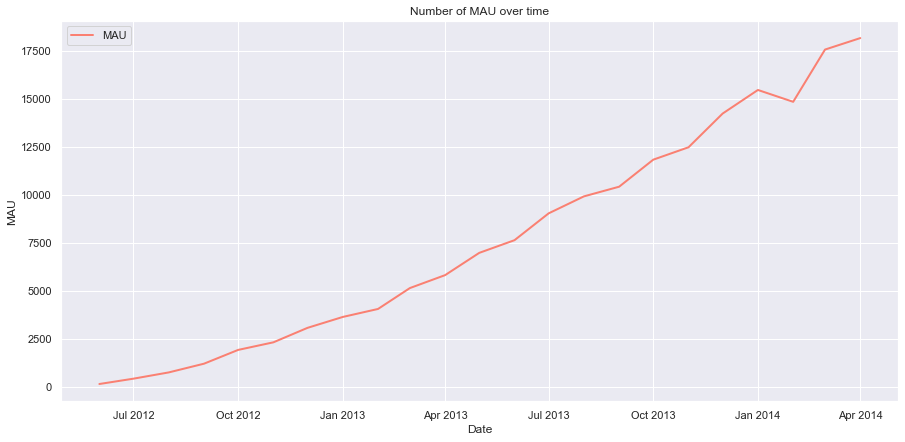

In [99]:
# Create a plot to see the trend of MAU 
fig, ax = plt.subplots() #create a new figure and one or more axes (subplots) to draw various plots or visualizations.
ax.plot(adopted_users_df_4['visited'], linewidth = 2, label = 'MAU', color = 'salmon')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('MAU')
ax.set_title('Number of MAU over time')


The plot shows a significant increase in MAU over 2 years period.

###  Further investigation

We are curious about how the MoM growth rate of adopted users in which if this is an actual increase or just relative over time based on the growth in the new users

In [118]:
adopted_users_lag_df = adopted_users_df_4.copy()
adopted_users_lag_df['lag'] = adopted_users_lag_df.shift(1, axis = 0)
adopted_users_lag_df['MoM'] = adopted_users_lag_df['visited'] - adopted_users_lag_df['lag']
adopted_users_lag_df = adopted_users_lag_df.dropna()

In [119]:
adopted_users_lag_df.head()

,visited,lag,MoM
time_stamp,,,
2012-07-01,432,154.0,278.0
2012-08-01,757,432.0,325.0
2012-09-01,1211,757.0,454.0
2012-10-01,1928,1211.0,717.0
2012-11-01,2323,1928.0,395.0


Text(0.5, 1.0, 'MoM over time')

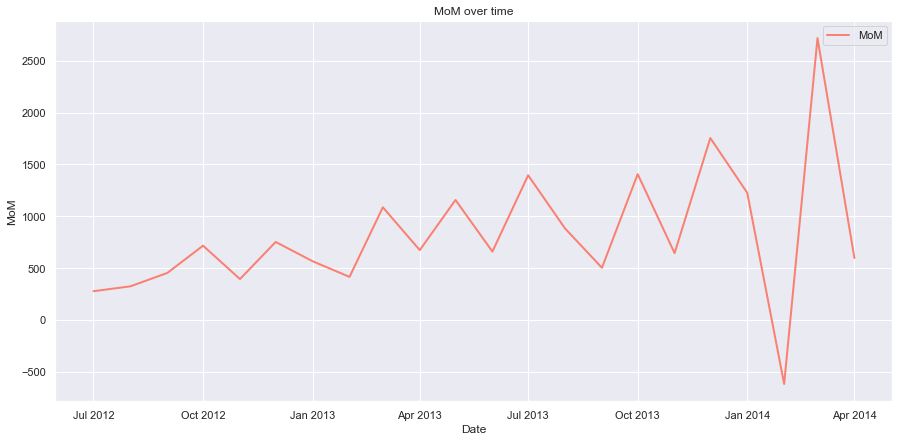

In [126]:
# Create a line plot to see the MoM growth rate of adopted users
fig, ax = plt.subplots()

ax.plot(adopted_users_lag_df['MoM'], linewidth = 2, label = 'MoM', color= "salmon") 

# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('MoM')
ax.set_title('MoM over time')

The graph shows that the adopted user MoM growth rate fluctuates through time with a gradual increase. Hence, the upward trend can be explained by the growth of new users.

## c. Calulate DAU/MAU ratio

In [128]:
adopted_users_df_5 = adopted_users_df_2.copy()
adopted_users_df_5 = adopted_users_df_5.reset_index()

adopted_users_df_5['month'] = pd.to_datetime(adopted_users_df_5['time_stamp']).dt.to_period('M')
adopted_users_df_5['month'] = adopted_users_df_5.month.values.astype('datetime64[M]')

adopted_users_df_5.head()

,time_stamp,visited,month
0,2012-05-31,2,2012-05-01
1,2012-06-01,1,2012-06-01
2,2012-06-02,1,2012-06-01
3,2012-06-03,2,2012-06-01
4,2012-06-04,2,2012-06-01


In [129]:
#reset index of MAU dataframe to join
adopted_users_df_6 = adopted_users_df_4.copy()
adopted_users_df_6 = adopted_users_df_6.reset_index()

adopted_users_df_6.head()

,time_stamp,visited
0,2012-06-01,154
1,2012-07-01,432
2,2012-08-01,757
3,2012-09-01,1211
4,2012-10-01,1928


In [132]:
print(adopted_users_df_5.shape)
print(adopted_users_df_6.shape)

(699, 3)
(23, 2)


In [133]:
# join 2 dataframe by month - year column
adopted_users_join_df = adopted_users_df_5.merge(adopted_users_df_6, left_on = 'month', right_on = 'time_stamp')

In [135]:
adopted_users_join_df.head()

,time_stamp_x,visited_x,month,time_stamp_y,visited_y
0,2012-06-01,1,2012-06-01,2012-06-01,154
1,2012-06-02,1,2012-06-01,2012-06-01,154
2,2012-06-03,2,2012-06-01,2012-06-01,154
3,2012-06-04,2,2012-06-01,2012-06-01,154
4,2012-06-05,4,2012-06-01,2012-06-01,154


In [137]:
adopted_users_join_df.shape


(698, 5)

In [138]:
# add new column DAU/MAU ratio which is the proportion of monthly active users who engage with your product in a single day window.
adopted_users_join_df['DAU/MAU'] = (adopted_users_join_df['visited_x']/adopted_users_join_df['visited_y'])*100
adopted_users_join_df.head()

,time_stamp_x,visited_x,month,time_stamp_y,visited_y,DAU/MAU
0,2012-06-01,1,2012-06-01,2012-06-01,154,0.649351
1,2012-06-02,1,2012-06-01,2012-06-01,154,0.649351
2,2012-06-03,2,2012-06-01,2012-06-01,154,1.298701
3,2012-06-04,2,2012-06-01,2012-06-01,154,1.298701
4,2012-06-05,4,2012-06-01,2012-06-01,154,2.597403


In [139]:
# filter out the timeframe that has outliers
adopted_users_join_df = adopted_users_join_df[adopted_users_join_df['time_stamp_y']>'2012-05-01']
adopted_users_join_df = adopted_users_join_df[adopted_users_join_df['time_stamp_x'] < '2014-05-01']

In [140]:
adopted_users_join_df.shape

(698, 6)

In [145]:
# prepare data for plotting
# keep only time_stamp_x and DAU/MAU columns
adopted_users_join_df_1 = adopted_users_join_df[['time_stamp_x', 'DAU/MAU']]

adopted_users_join_df_1['time_stamp_x'] = pd.to_datetime(adopted_users_join_df_1['time_stamp_x'])
adopted_users_join_df_1 = adopted_users_join_df_1 = adopted_users_join_df_1.set_index('time_stamp_x')

/var/folders/z4/gtdvl2k50kx0r_klc4vgllkh0000gn/T/ipykernel_4926/3457881267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_users_join_df_1['time_stamp_x'] = pd.to_datetime(adopted_users_join_df_1['time_stamp_x'])


In [155]:
adopted_users_join_df_1.head()


,DAU/MAU
time_stamp_x,
2012-06-01,0.649351
2012-06-02,0.649351
2012-06-03,1.298701
2012-06-04,1.298701
2012-06-05,2.597403


In [170]:
# adopted_users_join_df_1.loc[['2012-06-01']]

,DAU/MAU
time_stamp_x,
2012-06-01,0.649351


Text(0.5, 1.0, 'DAU/MAU ratio over time')

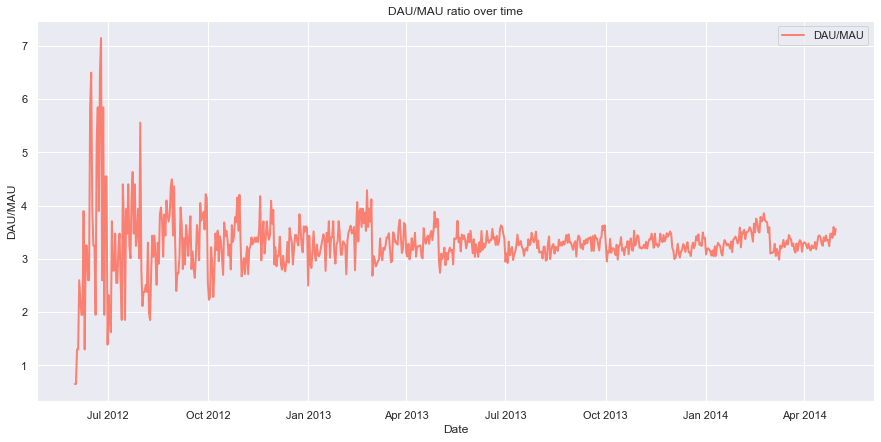

In [174]:
# create a line plot for stickness (DAU/MAU) over time
fig, ax = plt.subplots()

ax.plot(adopted_users_join_df_1['DAU/MAU'], linewidth = 2, label = 'DAU/MAU', color = 'salmon')

# set x-ticks to yearly interval and add legend and lables
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('DAU/MAU')
ax.set_title('DAU/MAU ratio over time')

Averange of DAU/MAU ratio in 2 years:


In [178]:
adopted_users_join_df_1.mean()

DAU/MAU    3.295129
dtype: float64

In [186]:
user_eng.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [201]:
# prepare to plot the count of new users each month

user_eng_df_1 = user_eng.copy()

# truncate date time data to month - year
user_eng_df_1['creation_time'] = pd.to_datetime(user_eng_df_1['creation_time']).dt.to_period('M')
user_eng_df_1['creation_time'] = user_eng_df_1.creation_time.values.astype('datetime64[M]')
user_eng_df_1 = user_eng_df_1[['creation_time', 'object_id']].groupby('creation_time').count()

In [202]:
user_eng_df_1.head()

,object_id
creation_time,
2012-05-01,16
2012-06-01,401
2012-07-01,387
2012-08-01,365
2012-09-01,409


Text(0.5, 1.0, 'New users over time')

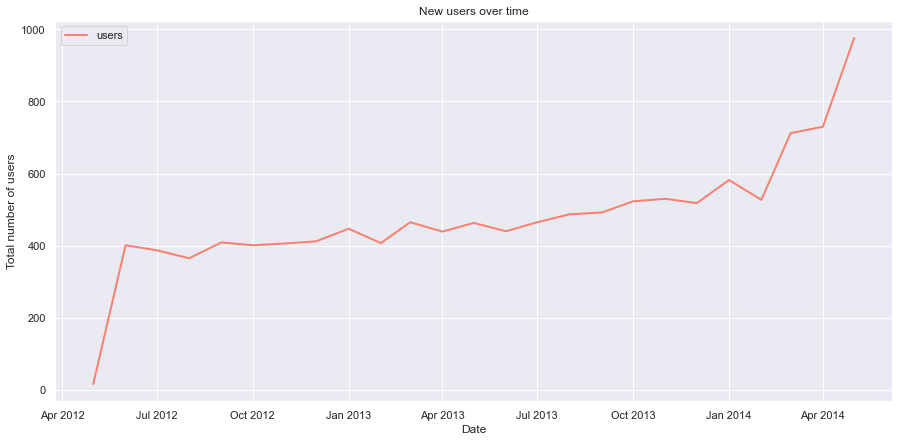

In [197]:
fig, ax = plt.subplots()

ax.plot(user_eng_df_1['object_id'],linewidth=2, label='users', color= "salmon")


# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Total number of users')
ax.set_title('New users over time')

The plot shows that there is a huge jump of new users over the past two years. Therefore, the high increasing rate we see before for DAU and MAU is due to the growth of new users

## Part II: Find the best predictors for the adopted users

### 1. EDA

In [204]:
# create a dummy variable to determine if a user is an adopted user or not
adopted_user_id['is_adopted_user'] = 1

In [217]:
user_eng.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [239]:
# Join adopted user dataframe woth original dataframe
adopted_users_join_df = pd.merge(adopted_user_id, user_eng,how='outer', left_on='user_id', right_on = 'object_id')

In [240]:
# fill in non-adopted users with 0s 
adopted_users_join_df['is_adopted_user'] = adopted_users_join_df['is_adopted_user'].fillna(0)


In [241]:
# convert unix time to uct time
adopted_users_join_df['last_session_creation_time'] = pd.to_datetime(adopted_users_join_df['last_session_creation_time']
                                                                     , unit = 's')
adopted_users_join_df['last_session_creation_time'] = adopted_users_join_df['last_session_creation_time'].dt.tz_localize('UCT')
adopted_users_join_df['creation_time'] = adopted_users_join_df['creation_time'].dt.tz_localize('UTC')



In [242]:
# Time from account creation to last login, we name it time delta
adopted_users_join_df['last_active_delta'] = (adopted_users_join_df['last_session_creation_time']\
                                                    - adopted_users_join_df['creation_time']).astype('timedelta64[D]')

In [244]:
adopted_users_join_df.head()

,user_id,is_adopted_user,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_active_delta
0,2.0,1.0,2,2013-11-15 03:45:04+00:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04+00:00,0,0,1,316.0,136.0
1,10.0,1.0,10,2013-01-16 22:08:03+00:00,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03+00:00,1,1,318,4143.0,503.0
2,33.0,1.0,33,2014-03-11 06:29:09+00:00,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,2014-05-31 06:29:09+00:00,0,0,401,79.0,81.0
3,42.0,1.0,42,2012-11-11 19:05:07+00:00,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,2014-05-25 19:05:07+00:00,1,0,235,NaN,560.0
4,50.0,1.0,50,2012-06-03 11:02:08+00:00,Oliveira Gabrielly,GabriellyAlmeidaOliveira@gmail.com,GUEST_INVITE,2012-10-23 11:02:08+00:00,0,0,61,50.0,142.0


In [246]:
# Find the number of value between adopted and non-adopted users
adopted_users_join_df['is_adopted_user'].value_counts()

0.0    10385
1.0     1615
Name: is_adopted_user, dtype: int64

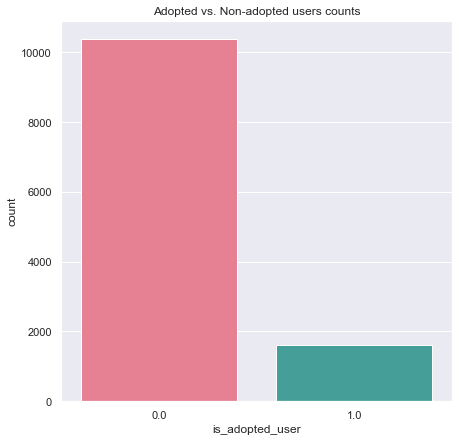

In [247]:
# plot the value counts of adopted and non-adopt users
sns.set(rc = {'figure.figsize':(7, 7)})

sns.countplot(x = 'is_adopted_user', data = adopted_users_join_df, palette = 'husl')
plt.title('Adopted vs. Non-adopted users counts')
plt.show()


In [257]:
count_df = adopted_users_join_df['is_adopted_user'].value_counts()
percent_adopted_user = round(count_df / count_df.sum()*100)

In [258]:
print('Percentage of no adopt is', percent_adopted_user[0])
print('Percentage of subscription is', percent_adopted_user[1])

Percentage of no adopt is 87.0
Percentage of subscription is 13.0


It is worth noticing that there is a imbalance between 2 classes of adopted and non-adopted users.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'PERSONAL_PROJECTS'),
  Text(3, 0, 'SIGNUP'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

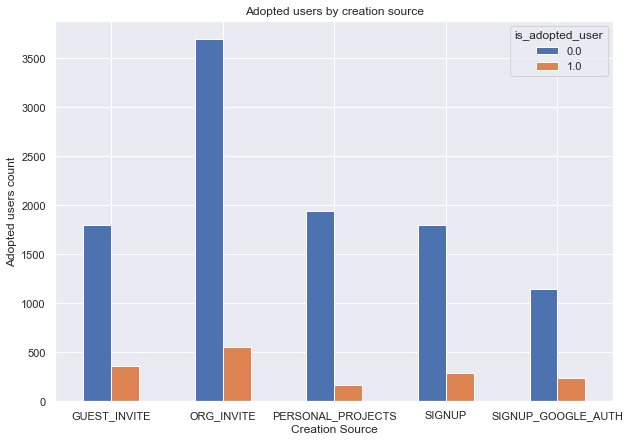

In [263]:
# create a bar plot to compare the total count between adopted and non-adopted users segment by creation source

sns.set(rc={'figure.figsize':(10, 7)})

pd.crosstab(adopted_users_join_df.creation_source, adopted_users_join_df.is_adopted_user).plot(kind='bar')
plt.title('Adopted users by creation source')
plt.xlabel('Creation Source')
plt.ylabel('Adopted users count')
plt.xticks(rotation=0)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

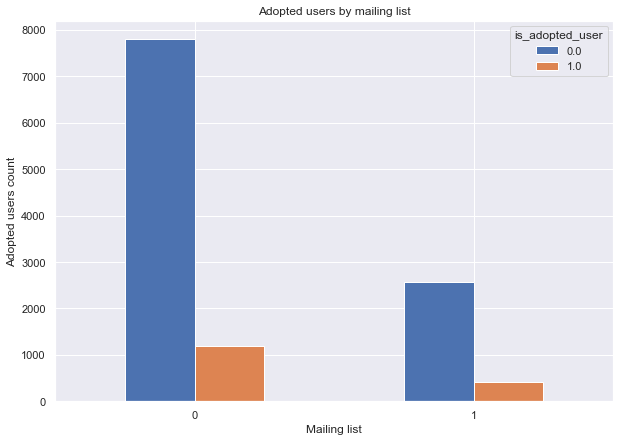

In [269]:
# draw the bar plot to compare the total count between adopted and non-adopted users segment

pd.crosstab(adopted_users_join_df.opted_in_to_mailing_list,adopted_users_join_df.is_adopted_user).plot(kind='bar')
plt.title('Adopted users by mailing list')
plt.xlabel('Mailing list')
plt.ylabel('Adopted users count')
plt.xticks(rotation=0)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

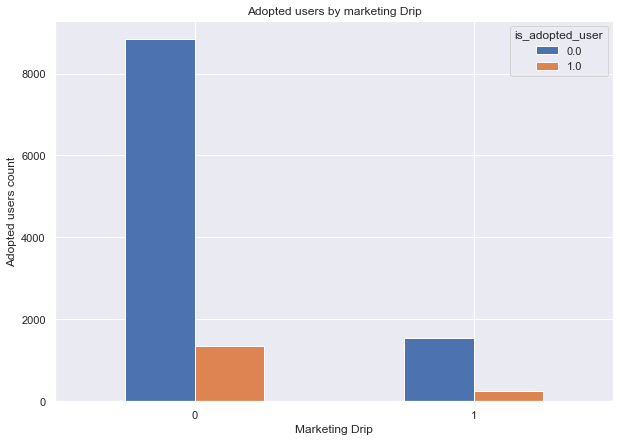

In [271]:
#draw the bar plot to compare the total count between adopted and non-adopt user segment by marketing drip
pd.crosstab(adopted_users_join_df.enabled_for_marketing_drip,adopted_users_join_df.is_adopted_user).plot(kind='bar')
plt.title('Adopted users by marketing Drip')
plt.xlabel('Marketing Drip')
plt.ylabel('Adopted users count')
plt.xticks(rotation=0)

In [287]:
#calculate the mean of related variables to adopted users
means_by_adopted = round(adopted_users_join_df.groupby('is_adopted_user').mean(),2)
means_by_adopted[means_by_adopted.columns[1:]]

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_active_delta
is_adopted_user,,,,,,
0.0,5991.12,0.25,0.15,138.63,5958.68,5.87
1.0,6060.82,0.26,0.16,162.78,5988.44,297.35


In [289]:
#calculate the mean of numerical varibales group by mailing list subscribers or not
means_by_mailing = round(adopted_users_join_df.groupby('opted_in_to_mailing_list').mean(),2)
means_by_mailing[means_by_mailing.columns[1:]]

,is_adopted_user,object_id,enabled_for_marketing_drip,org_id,invited_by_user_id,last_active_delta
opted_in_to_mailing_list,,,,,,
0,0.13,6065.15,0.05,141.64,5953.72,58.75
1,0.14,5806.02,0.45,142.62,5990.33,60.61


In [291]:
#calculate the mean of numerical varibales group by creation source
means_by_creation = round(adopted_users_join_df.groupby('creation_source').mean(),2)
means_by_creation[means_by_creation.columns[1:]]

,is_adopted_user,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_active_delta
creation_source,,,,,,,
GUEST_INVITE,0.17,5949.46,0.25,0.15,141.34,5912.55,74.85
ORG_INVITE,0.13,5981.86,0.25,0.15,138.94,5988.59,55.23
PERSONAL_PROJECTS,0.08,5975.33,0.24,0.14,144.29,NaN,67.56
SIGNUP,0.14,6020.83,0.25,0.15,146.25,NaN,50.31
SIGNUP_GOOGLE_AUTH,0.17,6145.20,0.24,0.15,141.52,NaN,58.12


In [294]:
#calculate the mean of numerical varibales group by marketing drip or not
means_by_marketing = round(adopted_users_join_df.groupby('enabled_for_marketing_drip').mean(),2)
means_by_marketing[means_by_marketing.columns[1:]]

,is_adopted_user,object_id,opted_in_to_mailing_list,org_id,invited_by_user_id,last_active_delta
enabled_for_marketing_drip,,,,,,
0,0.13,6032.49,0.16,141.40,5957.72,58.77
1,0.14,5818.27,0.75,144.63,5992.64,61.75


After the general EDA, we will now dummy the categorical value in creation source, and take into account other variables for our classification models to determine which variables are the best predictors for adopted users

### 2. Create dummy variables

In [355]:
adopted_users_join_df_1 = adopted_users_join_df[['is_adopted_user','creation_source',\
                                        'opted_in_to_mailing_list',\
                                        'enabled_for_marketing_drip']]

In [356]:
# splipt the unique values in "Creation source" and assign dummy values to earch
cat_vars = ['creation_source']

for var in cat_vars:
#     cat_list = 'var' + '_' +var
    cat_list = pd.get_dummies(adopted_users_join_df_1[cat_vars], prefix=cat_vars)
    adopted_users_join_df_2 = adopted_users_join_df_1.join(cat_list)
    adopted_users_join_df_1 = adopted_users_join_df_2

data_vars = adopted_users_join_df_1.columns.values.tolist()

to_keep = [i for i in data_vars if i not in cat_vars]
adopted_user_df_final = adopted_users_join_df_1[to_keep]



In [357]:
#print out the name of all columns that we just split from the creation source
adopted_user_df_final = adopted_user_df_final.rename(columns={"creation_source_GUEST_INVITE": "guest_invite", \
                                   "creation_source_ORG_INVITE": "org_invite",\
                         "creation_source_PERSONAL_PROJECTS": "personal_project",\
                         "creation_source_SIGNUP": "website_signup",\
                         "creation_source_SIGNUP_GOOGLE_AUTH": "google_signup" })
adopted_user_df_final.columns.values

array(['is_adopted_user', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'guest_invite', 'org_invite',
       'personal_project', 'website_signup', 'google_signup'],
      dtype=object)

In [358]:
adopted_user_df_final.shape

(12000, 8)

### 3. Over-sampling using SMOTE

In [392]:
# splipt predictors and response variables
y = adopted_user_df_final['is_adopted_user']
X = adopted_user_df_final.loc[:,adopted_user_df_final.columns != 'is_adopted_user']

In [395]:
# resampling data
os = SMOTE(random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [397]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(8400, 7)
(3600, 7)
(3600,)
(8400,)


In [409]:
# deal with imbalance issue 
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['is_adopted_user'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['is_adopted_user']==0]))
print("Number of subscription",len(os_data_y[os_data_y['is_adopted_user']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['is_adopted_user']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['is_adopted_user']==1])/len(os_data_X))

length of oversampled data is  14510
Number of no subscription in oversampled data 7255
Number of subscription 7255
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


### 4. Feature Importance Selection

#### 4.1.  XGBoost model 

In [422]:
# take response and explain date from balanced dataset
X = os_data_X
y = os_data_y['is_adopted_user']

In [423]:
# train test splipt
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.3, random_state=0)

In [426]:
# hyperparameter tuning for XGBoost
param_test = {
    'max_dept':range(3,10,2),
    'min_child_weight':range(1, 6, 2)
}

gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)

gsearch.fit(X_train_xgb, y_train_xgb)

# print out the best score
print(gsearch.best_params_, gsearch.best_score_)
 


[11:15:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

{'max_dept': 3, 'min_child_weight': 1} 0.5750251985399902


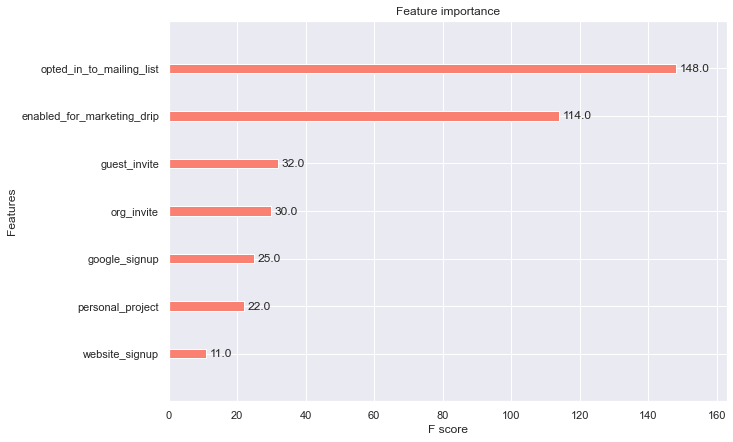

[11:15:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10

[11:15:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_dept" } are not used.

[11:15:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10

In [430]:
# using XGboost for feature importance
xgb = XGBClassifier(max_depth = 3, min_child_weight = 1)
xgb.fit(X_train_xgb, y_train_xgb)

# plot feature importance
plot_importance(xgb, color='salmon')
pyplot.show()

In [432]:
# apply all feartured classifier to the test data
y_pred_xgb = xgb.predict(X_test_xgb)

xgb.fit(X_train_xgb, y_train_xgb)
print("Accuracy on training set: {:.3f}".format(xgb.score(X_train_xgb, y_train_xgb)))
print("Accuracy on test set: {:.3f}".format(xgb.score(X_test_xgb, y_test_xgb)))
                        

Accuracy on training set: 0.554
Accuracy on test set: 0.550


In [438]:
# percent accurancy 
round((y_pred_xgb == y_test_xgb).mean(),3)

0.55

In [442]:
# confusion matrix
confusion_matrix_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
confusion_matrix_xgb 

array([[1449,  731],
       [1228,  945]])

This means that there are 1,449 + 945 = 2,394 correct predictions and incorrect perdictions 1,228 + 731 = 1,959

#### 4.2. Random forest model

In [457]:
# create labels
predict_labels = list(X_train_xgb.columns)

In [460]:
# take response and explain date from balanced dataset
X = os_data_X
y = os_data_y['is_adopted_user']

In [461]:
# Splipt the dataset into train and test dataset
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.3, random_state=0)


**Use the gridsearch to find the best model for the Random Forest**

In [462]:
# Generate the random grid to fit in the Gridsearch
# Number of trees in the random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [463]:
# Use the random grid to search for best hyperparameter
# Create the base model to tune
rf = RandomForestRegressor()

# For random search of parameters, using 5 fold cross validation, 
# search across 150 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150,\
                               cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model and select the best param
rf_random.fit(X_train_rf, y_train_rf)
rf_random.best_params_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [464]:
# Find the best parameters to fit in the random forest model
# RF model
rf = RandomForestClassifier(n_estimators= 400, min_samples_split= 10, min_samples_leaf= 4, \
                             max_features= 'sqrt', max_depth= 90, bootstrap= True)

# Train the classifier
rf.fit(X_train_rf, y_train_rf)



RandomForestClassifier(max_depth=90, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400)

In [466]:
# Print the name and gini importance of each feature
for feature in zip(predict_labels, rf.feature_importances_):
    print(feature)

('opted_in_to_mailing_list', 0.0910188406771678)
('enabled_for_marketing_drip', 0.049773933679301094)
('guest_invite', 0.1253125437540317)
('org_invite', 0.06290707135963931)
('personal_project', 0.43723325825843046)
('website_signup', 0.043402895824525826)
('google_signup', 0.19035145644690385)


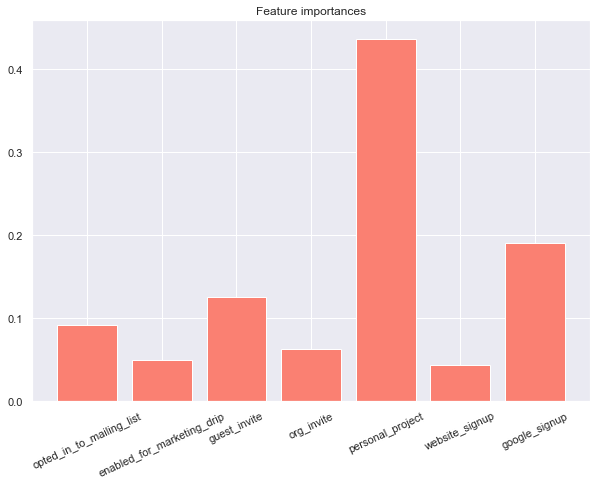

In [467]:
plt.figure()
sns.set(rc={'figure.figsize':(20, 10)})
plt.title("Feature importances")
plt.bar(predict_labels,rf.feature_importances_, align="center", color='salmon')
plt.xticks(predict_labels)
plt.xticks(rotation=25)
plt.show()

It is worth noting that 'personal_project', 'guest_invite', and 'google_signup' are three most impotance features.

In [469]:
# Apply The Full Featured Classifier To The Test Data
y_pred_rf = rf.predict(X_test_rf)

rf.fit(X_train_rf, y_train_rf)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train_rf, y_train_rf)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test_rf, y_test_rf)))

Accuracy on training set: 0.554
Accuracy on test set: 0.550


In [472]:
# Pecent accuracy of the model
round((y_pred_rf == y_test_rf).mean(), 3)


0.55

It has the same accuracy as the XGBoost model.

In [473]:
#Confusion metrics
confusion_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)
print(confusion_matrix_rf)

[[1449  731]
 [1228  945]]


This means that we 1,449 + 945 = 2,394 correct predictions and incorrecly classify 1,228 + 731 = 1,959

#### Conclusion for feature important:

Since we see the important features differ for XGBoost and Random Forest given the same accuracy, these are potential reasons:

- When there are several correlated features, XGBoost will tend to choose one and use it in several trees so other correlated features won t be used a lot (or probably not at all). Therefore, other correlated features can't help in the split process anymore, and they don't bring new information regarding the already used feature. 

- On the other hand, each tree of a Random forest is not built from the same features since there is a random selection of features to use for each tree. Hence, each correlated feature may have the chance to be selected in one of the tree. Therefore, the learning is done in parallel so each tree is not aware of what have been used for other trees.

We are going to **test the correlation** between variables choosing the right model for feature importance:

/var/folders/z4/gtdvl2k50kx0r_klc4vgllkh0000gn/T/ipykernel_4926/453040004.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


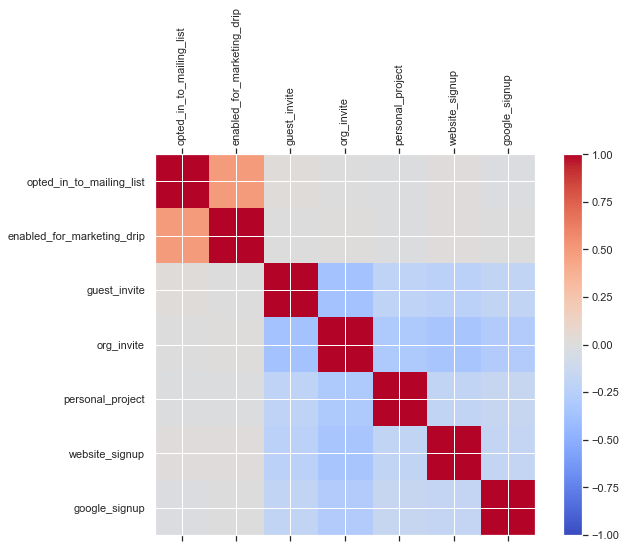

In [479]:
#correlation for variables in X
corr = X.corr()
sns.set(rc={'figure.figsize':(10, 7)})

#Plot the correlation
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

Some variables are highly correlated with each other in different ways, therefore, we will go with Random Forest as a more unbiased and precise decision in this case.

### Logistics regression - Analyse the significant of each variable on adopted users

In [480]:
# implement the model
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.683473
         Iterations 4
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.014     
Dependent Variable:     is_adopted_user     AIC:                 19848.3954
Date:                   2023-07-29 12:31    BIC:                 19901.4736
No. Observations:       14510               Log-Likelihood:      -9917.2   
Df Model:               6                   LL-Null:             -10058.   
Df Residuals:           14503               LLR p-value:         1.0932e-57
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         4.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
opted_in_to_maili

According to the p-value and coefficients:
- Since the p-value of Guest_invite, Personal_Projects and Google signup are smaller than 0.05 significant level, we will take these values in our classification model as they are statistically significant. Org_invite seems to have small effect since the p-value is approximately 0.05, we can also take into acount this variables for our model this time

- From the coefficients, we can see that by having one 1 additional in Guest_invite, we will have 25% increase in the odd of adopted users since $e^{0.227}$ = 1.25, while it is 42% for Google signup as $e^{0.354}$ = 1.42. 

- On the other had, it's pretty counterintuitive that Org_invite and Personal projects have negative coefs, which means that they have negative effect on the odd of adopted users. In particular, an increase in 1 org_invite will decrease the odd of adopted users by 6% ($e^{0.0581}$ = 1.059). Likewise, 1 additional Personal_project signup will decrease the odd of adopted user by 81% ($e^{0.5935}$ = 1.81)

In [482]:
# Since there are only Guest_invite, Personal_Projects, Google signup, Org_invite are significant, we will only include them in our model

X = X[['guest_invite', 'org_invite','personal_project', 'website_signup', 'google_signup']]
y = y

#train test split
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X, y, test_size=0.3, random_state=0)


In [483]:
#generate random grid with l2 penalty
grid={"C":np.logspace(0.01,0.001,10,100,1000), "penalty":["l2"]}# l2 ridge
logreg=LogisticRegression(solver='lbfgs')
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train_logit,y_train_logit)

#choosing the best parameters
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 1.0715193052376064, 'penalty': 'l2'}
accuracy : 0.5449453742580552


In [484]:
# train the model
logreg1 = LogisticRegression(C=1.07)
logreg1.fit(X_train_logit, y_train_logit)


LogisticRegression(C=1.07)

In [485]:
y_pred_logit = logreg1.predict(X_test_logit)


logreg1.fit(X_train_logit, y_train_logit)
print("Accuracy on training set: {:.3f}".format(logreg1.score(X_train_logit, y_train_logit)))
print("Accuracy on test set: {:.3f}".format(logreg1.score(X_test_logit, y_test_logit)))


Accuracy on training set: 0.548
Accuracy on test set: 0.545


In [487]:
# pecent accurancy 
round((y_pred_logit == y_test_logit).mean(), 3)

0.545

In [488]:
#Confusion metrics
confusion_matrix_logit = confusion_matrix(y_test_logit, y_pred_logit)
print(confusion_matrix_logit)

[[1561  619]
 [1361  812]]


This means that we correctly classify 1,561 + 812 = 2,373 and incorrecly classify 1172 + 796 = 1,980

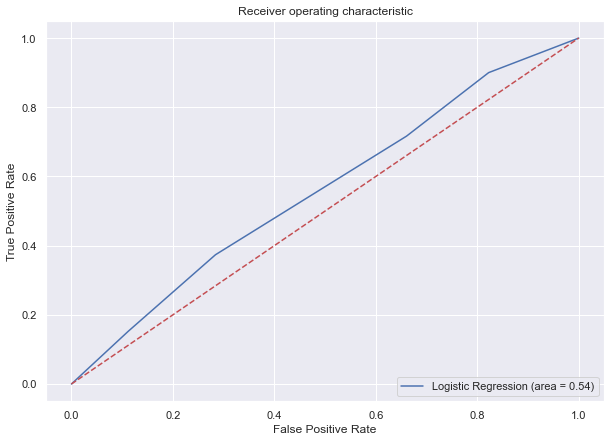

In [489]:
logit_roc_auc = roc_auc_score(y_test_logit, logreg1.predict(X_test_logit))
fpr, tpr, thresholds = roc_curve(y_test_logit, logreg1.predict_proba(X_test_logit)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 6. Logistic Regression for last active time delta:

We will now do a separate model for the time delta to see the significance of this variable on adopted user

In [509]:
adopted_users_join_df_1 = adopted_users_join_df.dropna(subset=['last_active_delta'])
X_delta = adopted_users_join_df_1[['last_active_delta']]
y_delta = adopted_users_join_df_1[['is_adopted_user']]

#train split test
X_train_delta, X_test_delta, y_train_delta, y_test_delta = train_test_split(X_delta, y_delta, test_size=0.3, random_state=0)


In [503]:
logit_model=sm.Logit(y_delta,X_delta)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.622126
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.307    
Dependent Variable: is_adopted_user  AIC:              10980.0417
Date:               2023-07-29 16:39 BIC:              10987.1269
No. Observations:   8823             Log-Likelihood:   -5489.0   
Df Model:           0                LL-Null:          -4199.6   
Df Residuals:       8822             LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
last_active_delta    0.0093   0.0005 20.6497 0.0000 0.0084 0.0102



- Since the p-value of last_active_delta variable is smaller than 0.05, we can conclude the last_active_delta is statistically significance.
- Increasing 1 addition last_active_delta will increase the odd of adopted users by 0.93% as $e^{0.0093} = 1.0093$.
- This also hows that the longer a user stay active on the platform they will be more likely to be adopted.

In [510]:
# train the model
logreg2 = LogisticRegression(C=1.07)
logreg2.fit(X_train_delta, y_train_delta)

/Users/chinguyen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.07)

In [511]:
y_pred_delta = logreg2.predict(X_test_delta)


logreg2.fit(X_train_delta, y_train_delta)
print("Accuracy on training set: {:.3f}".format(logreg2.score(X_train_delta, y_train_delta)))
print("Accuracy on test set: {:.3f}".format(logreg2.score(X_test_delta, y_test_delta)))


Accuracy on training set: 0.962
Accuracy on test set: 0.962


/Users/chinguyen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [531]:
confusion_matrix_delta = confusion_matrix(y_test_delta, y_pred_delta)
print(confusion_matrix_delta)

[[2130   33]
 [  67  417]]


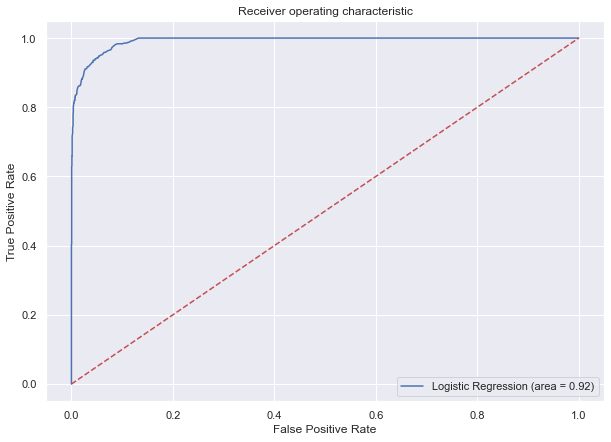

In [532]:
logit_roc_auc = roc_auc_score(y_test_delta, logreg2.predict(X_test_delta))
fpr, tpr, thresholds = roc_curve(y_test_delta, logreg2.predict_proba(X_test_delta)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()